### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, pickle, gzip

In [2]:
import sys
from pathlib import Path
# if notebook is in PMLS_project/notebooks, add PMLS_project
sys.path.insert(0, str(Path.cwd().parent))

## Functions

In [ ]:
def pt_diagnostics_report(
    I_ts_stack,
    betas=None,
    acc_stack=None,
    *,
    q_lo=0.20,                  # disorder-guard quantile for acceptance summaries
    burn_in=0,                  # int steps, or float fraction in (0,1)
    chains=(0, 1),              # which independent chains to analyze (if present)
    plot_disorders=10,           # how many representative disorders to plot as lines
    trace_walkers=6,            # how many walkers to show in k_w(t) traces
    trace_disorder="worst",     # "worst" | "median" | int disorder index
    trace_chain=0,
    save_prefix=None,           # e.g. "diag_" -> saves diag_*.png
    show=True,
):
    """
    Drop-in PT diagnostics from I_ts (slot->walker time series) and optional acc_stack.

    Expected shapes:
      - I_ts_stack: (R, B, T, K) or (B, T, K) or (T, K)
      - acc_stack : (R, K-1) or (K-1,) (optional)

    Returns a dict of computed metrics (arrays are numpy).
    Produces plots (matplotlib) unless show=False.
    """


    # ---------- normalize input shapes ----------
    I = np.asarray(I_ts_stack)
    if I.ndim == 4:
        R, B, T, K = I.shape
    elif I.ndim == 3:
        R = 1
        B, T, K = I.shape
        I = I[None, ...]
    elif I.ndim == 2:
        R = 1
        B = 1
        T, K = I.shape
        I = I[None, None, ...]
    else:
        raise ValueError("I_ts_stack must have shape (R,B,T,K), (B,T,K), or (T,K).")

    if betas is None:
        beta = None
    else:
        beta = np.asarray(betas, float)
        if beta.shape[0] != K:
            raise ValueError(f"betas length {beta.shape[0]} does not match K={K}.")

    # burn-in
    if isinstance(burn_in, float):
        if not (0.0 <= burn_in < 1.0):
            raise ValueError("burn_in as float must be in [0,1).")
        t0 = int(np.floor(burn_in * T))
    else:
        t0 = int(burn_in)
    t0 = max(0, min(t0, T - 1))
    Teff = T - t0

    temperatures = np.sort(1/np.asarray(betas))


    # chains to analyze
    chains = tuple(int(c) for c in chains)
    for c in chains:
        if not (0 <= c < B):
            raise ValueError(f"chain index {c} out of range for B={B}.")

    hot_k, cold_k = 0, K - 1

    # ---------- helpers ----------
    def _roundtrips_from_ends(w_hot, w_cold, K):
        """
        Hot-based round trips: hot->cold->hot for each walker.
        Returns (rt_times list, n_rt, rt_rate).
        """
        t_hot_start = np.full(K, -1, dtype=np.int64)
        seen_cold   = np.zeros(K, dtype=np.bool_)
        rts = []

        for t in range(w_hot.shape[0]):
            wh = int(w_hot[t])
            wc = int(w_cold[t])

            # cold visit marks success-in-between if a hot-start exists
            if t_hot_start[wc] != -1:
                seen_cold[wc] = True

            # hot visit closes a round trip if cold was seen
            if t_hot_start[wh] != -1 and seen_cold[wh]:
                rts.append(t - t_hot_start[wh])

            # (re)start from hot
            t_hot_start[wh] = t
            seen_cold[wh] = False

        n_rt = len(rts)
        rt_rate = n_rt / max(1, w_hot.shape[0])
        return rts, n_rt, rt_rate

    def _passages_from_ends(w_hot, w_cold, K):
        """
        One-way end-to-end passage times:
          - hot->cold and cold->hot, using "last end visited" timestamps per walker.
        Returns two lists: tau_hc, tau_ch.
        """
        last_end = np.zeros(K, dtype=np.int8)     # 0 none, +1 hot, -1 cold
        last_t   = np.full(K, -1, dtype=np.int64)

        tau_hc = []
        tau_ch = []

        for t in range(w_hot.shape[0]):
            wh = int(w_hot[t])
            wc = int(w_cold[t])

            # cold hit
            if last_end[wc] == +1:
                tau_hc.append(t - last_t[wc])
            last_end[wc] = -1
            last_t[wc] = t

            # hot hit
            if last_end[wh] == -1:
                tau_ch.append(t - last_t[wh])
            last_end[wh] = +1
            last_t[wh] = t

        return tau_hc, tau_ch

    def _flow_profile_f(I_bt):
        """
        Directional flow profile f(k) from one chain:
        I_bt: (Teff, K) slot->walker.
        Implements:
          label walker by last end visited: +1 (hot), -1 (cold), 0 unknown.
          f(k) = P(label=+1 | at slot k), estimated over time, excluding unknown labels.
        Returns:
          f: (K,) with NaNs possible if denom=0 at a slot (unlikely)
          denom: (K,) number of labeled samples accumulated at each slot
        """
        labels = np.zeros(K, dtype=np.int8)  # per walker: 0 unknown, +1 hot, -1 cold
        num = np.zeros(K, dtype=np.float64)
        den = np.zeros(K, dtype=np.float64)

        for t in range(I_bt.shape[0]):
            wh = int(I_bt[t, hot_k])
            wc = int(I_bt[t, cold_k])
            labels[wh] = +1
            labels[wc] = -1

            lab_slots = labels[I_bt[t]]  # (K,)
            known = (lab_slots != 0)
            den[known] += 1.0
            num[known] += (lab_slots[known] == +1)

        f = np.full(K, np.nan, dtype=np.float64)
        mask = den > 0
        f[mask] = num[mask] / den[mask]
        return f, den

    def _invert_perm(I_t):
        """Given I_t (K,) slot->walker, return k_of_w (K,) walker->slot."""
        k_of_w = np.empty(K, dtype=np.int16)
        k_of_w[I_t.astype(np.int64)] = np.arange(K, dtype=np.int16)
        return k_of_w

    def _backtracking_rho1(I_bt, walkers=None):
        """
        Backtracking correlation rho1 = Corr(delta k(t), delta k(t+1)) for selected walkers,
        where k_w(t) is walker position (slot index).
        Returns:
          rho_w: (len(walkers),) rho1 per walker (NaN if too few moves)
          rho_med: median rho1 ignoring NaNs
        """
        Te = I_bt.shape[0]
        if walkers is None:
            walkers = np.arange(K, dtype=np.int64)
        else:
            walkers = np.asarray(walkers, dtype=np.int64)

        # build k_w(t) for selected walkers only, streaming
        k_prev = _invert_perm(I_bt[0])[walkers].astype(np.int16)
        dk_prev = None
        xs = [[] for _ in range(walkers.size)]
        ys = [[] for _ in range(walkers.size)]

        for t in range(1, Te):
            k_now = _invert_perm(I_bt[t])[walkers].astype(np.int16)
            dk = (k_now - k_prev).astype(np.int16)
            if dk_prev is not None:
                for i in range(walkers.size):
                    xs[i].append(int(dk_prev[i]))
                    ys[i].append(int(dk[i]))
            dk_prev = dk
            k_prev = k_now

        rho = np.full(walkers.size, np.nan, dtype=np.float64)
        for i in range(walkers.size):
            x = np.array(xs[i], dtype=np.float64)
            y = np.array(ys[i], dtype=np.float64)
            if x.size >= 10 and np.std(x) > 0 and np.std(y) > 0:
                rho[i] = np.corrcoef(x, y)[0, 1]
        rho_med = np.nanmedian(rho)
        return rho, rho_med

    # ---------- compute per-disorder, per-chain metrics ----------
    rt_count = np.zeros((R, B), dtype=np.int64)
    rt_rate  = np.zeros((R, B), dtype=np.float64)
    rt_med   = np.full((R, B), np.nan, dtype=np.float64)

    tau_hc_med = np.full((R, B), np.nan, dtype=np.float64)
    tau_ch_med = np.full((R, B), np.nan, dtype=np.float64)

    f_prof = np.full((R, B, K), np.nan, dtype=np.float64)
    f_slope_max = np.full((R, B), np.nan, dtype=np.float64)

    rho1_med = np.full((R, B), np.nan, dtype=np.float64)

    for r in range(R):
        for b in chains:
            I_bt = I[r, b, t0:, :].astype(np.int64)  # (Teff,K)
            w_hot  = I_bt[:, hot_k]
            w_cold = I_bt[:, cold_k]

            rts, nrt, rate = _roundtrips_from_ends(w_hot, w_cold, K)
            rt_count[r, b] = nrt
            rt_rate[r, b]  = rate
            if rts:
                rt_med[r, b] = float(np.median(np.array(rts, dtype=np.int64)))

            tau_hc, tau_ch = _passages_from_ends(w_hot, w_cold, K)
            if tau_hc:
                tau_hc_med[r, b] = float(np.median(np.array(tau_hc, dtype=np.int64)))
            if tau_ch:
                tau_ch_med[r, b] = float(np.median(np.array(tau_ch, dtype=np.int64)))

            f, _den = _flow_profile_f(I_bt)
            f_prof[r, b, :] = f
            if np.all(np.isnan(f)):
                f_slope_max[r, b] = np.nan
            else:
                df = np.diff(f)
                f_slope_max[r, b] = np.nanmax(np.abs(df))

            # backtracking correlation on a small subset of walkers (cheap + informative)
            walkers = np.linspace(0, K - 1, min(trace_walkers, K), dtype=np.int64)
            _rho, rho_med_val = _backtracking_rho1(I_bt, walkers=walkers)
            rho1_med[r, b] = rho_med_val

    # ---------- acceptance aggregation (optional) ----------
    acc_summary = None
    if acc_stack is not None:
        A = np.asarray(acc_stack, float)
        if A.ndim == 1:
            if A.shape[0] != K - 1:
                raise ValueError("acc_stack length must be K-1.")
            acc_med = A.copy()
            acc_lo  = A.copy()
            acc_hi  = A.copy()
        elif A.ndim == 2:
            if A.shape[1] != K - 1:
                raise ValueError("acc_stack must have shape (R,K-1).")
            acc_med = np.quantile(A, 0.50, axis=0)
            acc_lo  = np.quantile(A, q_lo, axis=0)
            acc_hi  = np.quantile(A, 1.0 - q_lo, axis=0)
        else:
            raise ValueError("acc_stack must be shape (K-1,) or (R,K-1).")

        acc_summary = dict(acc_med=acc_med, acc_lo=acc_lo, acc_hi=acc_hi)

    # ---------- choose representative disorders ----------
    # Use median over analyzed chains of rt_rate to rank disorders
    rt_rate_used = np.nanmedian(rt_rate[:, list(chains)], axis=1)
    worst_r = int(np.nanargmin(rt_rate_used))
    best_r  = int(np.nanargmax(rt_rate_used))
    med_r   = int(np.argsort(rt_rate_used)[len(rt_rate_used)//2]) if R > 1 else 0

    if trace_disorder == "worst":
        trace_r = worst_r
    elif trace_disorder == "median":
        trace_r = med_r
    elif isinstance(trace_disorder, int):
        trace_r = int(trace_disorder)
    else:
        raise ValueError("trace_disorder must be 'worst', 'median', or an int index.")

    reps = [worst_r, med_r, best_r]
    reps = reps[:min(plot_disorders, len(reps))]

    # ---------- plots ----------
    figs = []

    # 1) Acceptance per interface (median/low/high quantiles across disorders)
    if acc_summary is not None:
        fig = plt.figure(figsize=(7, 3.8))
        x = np.arange(K - 1)
        plt.axhline(0.2, linestyle="--")
        plt.plot(x,A.min(axis=0), marker="o", linestyle=":", label="acc min")
        plt.plot(x, acc_summary["acc_med"], marker="o", linestyle="-", label="acc median")
        plt.plot(x, acc_summary["acc_lo"],  marker="o", linestyle="--", label=f"acc q={q_lo:.2f}")
        plt.plot(x, acc_summary["acc_hi"],  marker="o", linestyle="--", label=f"acc q={1-q_lo:.2f}")
        plt.xlabel("interface k (between β_k and β_{k+1})")
        plt.ylabel("acceptance")
        plt.title("Swap acceptance summaries across disorder")
        plt.legend()
        plt.tight_layout()
        figs.append(("acceptance", fig))

    # 2) Round-trip rate per disorder (scatter)
    fig = plt.figure(figsize=(7, 3.8))

    rate1 = 100 / max(1, Teff)
    rate2 = 2/ max(1, Teff)
    plt.axhline(rate1, linestyle="--",label=f"{100} round trips")
    plt.axhline(rate2, linestyle="--",label=f"{2} round trips")
    x = np.arange(R)
    for b in chains:
        plt.plot(x, rt_rate[:, b], marker="o", linestyle="none", label=f"chain {b}")
    plt.xlabel("disorder index r")
    plt.ylabel("round trips per step")
    plt.title(f"Round-trip rate (burn-in t0={t0}, Teff={Teff})")
    #plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    figs.append(("rt_rate", fig))

    # 3) Round-trip time median per disorder
    fig = plt.figure(figsize=(7, 3.8))
    for b in chains:
        plt.plot(x, rt_med[:, b], marker="o", linestyle="none", label=f"chain {b}")
    plt.xlabel("disorder index r")
    plt.ylabel("median RT time (steps)")
    plt.title("Median hot→cold→hot round-trip time")
    #plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    figs.append(("rt_median_time", fig))

    order = np.argsort(rt_rate_used)          # worst -> best
    mid = len(order) // 2

    groups = {
        "worst 3": order[:3],
        "median ±1": order[max(0, mid-1):min(len(order), mid+2)],
        "best 3": order[-3:],
    }

    x = np.arange(K)  # slot index; or use beta / (1/beta) if you want later

    fig, axes = plt.subplots(1, 3, figsize=(12, 3.8), sharey=True)
    for ax, (title, idxs) in zip(axes, groups.items()):
        for r in idxs:
            for b in chains:
                ax.plot(x, f_prof[r, b], marker="o", linestyle="-", label=f"r={r}, b={b}")
        ax.set_title(title)
        ax.set_xlabel("slot k (0 hot → K-1 cold)")
    axes[0].set_ylabel("f(k)")
    axes[0].legend(ncol=1, fontsize=8)
    plt.tight_layout()
    figs.append(("flow_groups", fig))


    # 5) Heatmap of f(k) across disorders (one chain)
    if R > 1:
        fig = plt.figure(figsize=(7, 4.2))
        M = f_prof[:, trace_chain, :]
        plt.imshow(M, aspect="auto", interpolation="nearest")
        plt.colorbar(label="f(k)")
        plt.xlabel("temperature slot k")
        plt.ylabel("disorder index r")
        plt.title(f"f(k) heatmap across disorders (chain {trace_chain})")
        plt.tight_layout()
        figs.append(("flow_heatmap", fig))

    # 6) Walker traces k_w(t) for a few walkers in a chosen disorder
    # This is where k_ts matters: for visualization/debug of "bouncing"/plateaus.
    fig = plt.figure(figsize=(7, 4.2))
    I_bt = I[trace_r, trace_chain, t0:, :].astype(np.int64)
    Te = I_bt.shape[0]
    walkers = np.linspace(0, K - 1, min(trace_walkers, K), dtype=np.int64)

    # build k_w(t) for selected walkers
    k_tr = np.empty((Te, walkers.size), dtype=np.int16)
    for t in range(Te):
        k_of_w = _invert_perm(I_bt[t])
        k_tr[t, :] = k_of_w[walkers]

    t_axis = np.arange(Te)
    for i, w in enumerate(walkers):
        plt.plot(t_axis, k_tr[:, i], linestyle="-", label=f"w={int(w)}")
    plt.xlabel("time step (post burn-in)")
    plt.ylabel("temperature slot k_w(t)")
    plt.title(f"Walker temperature trajectories (r={trace_r}, chain={trace_chain})")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    figs.append(("walker_traces", fig))

    # 7) Backtracking (rho1) per disorder
    fig = plt.figure(figsize=(7, 3.8))
    for b in chains:
        plt.plot(np.arange(R), rho1_med[:, b], marker="o", linestyle="none", label=f"chain {b}")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("disorder index r")
    plt.ylabel("median ρ₁ over sampled walkers")
    plt.title("Backtracking indicator: Corr(Δk(t), Δk(t+1))")
    plt.legend()
    plt.tight_layout()
    figs.append(("backtracking", fig))

    # ---------- save / show ----------
    if save_prefix is not None:
        for name, fig in figs:
            fig.savefig(f"{save_prefix}{name}.png", dpi=150)

    if show:
        plt.show()
    else:
        # avoid GUI side effects; caller can manage figures
        pass

    # ---------- return metrics ----------
    out = dict(
        shape=dict(R=R, B=B, T=T, K=K, burn_in=t0, Teff=Teff),
        betas=beta,
        acc_summary=acc_summary,
        rt_count=rt_count,
        rt_rate=rt_rate,
        rt_med=rt_med,
        tau_hc_med=tau_hc_med,
        tau_ch_med=tau_ch_med,
        f_profile=f_prof,
        f_slope_max=f_slope_max,
        rho1_med=rho1_med,
        representative=dict(worst=worst_r, median=med_r, best=best_r, trace=trace_r),
    )
    return out

In [4]:
def compare_pt_diagnostics_3x2(
    I_ts_t0_stack, betas_t0, acc_t0_stack,
    I_ts_t05_stack, betas_t05, acc_t05_stack,
    *,
    q_lo=0.20,
    burn_in=0,              # int steps, or float fraction in [0,1)
    chains=(0, 1),
    titles=("t = 0", "t = 0.5"),
    show=True,
):
    """
    Make a 3x2 comparison figure:
      col 0: t=0, col 1: t=0.5
      row 1: acceptance summaries
      row 2: median RT time (hot→cold→hot), log y
      row 3: flow profile heatmap, with both chains stacked (rows = r*B + b)

    Expected shapes:
      I_ts_*_stack: (R, B, T, K)
      betas_*     : (K,)
      acc_*_stack : (R, K-1)
    """

    def _burn_t0(T, burn_in):
        if isinstance(burn_in, float):
            if not (0.0 <= burn_in < 1.0):
                raise ValueError("burn_in as float must be in [0,1).")
            return int(np.floor(burn_in * T))
        t0 = int(burn_in)
        return max(0, min(t0, T - 1))

    def _roundtrip_medians(I, t0, chains):
        # I: (R,B,T,K) slot->walker
        R, B, T, K = I.shape
        hot_k, cold_k = 0, K - 1
        rt_med = np.full((R, B), np.nan, dtype=float)

        for r in range(R):
            for b in chains:
                I_bt = I[r, b, t0:, :].astype(np.int64)
                w_hot  = I_bt[:, hot_k]
                w_cold = I_bt[:, cold_k]

                t_hot_start = np.full(K, -1, dtype=np.int64)
                seen_cold   = np.zeros(K, dtype=bool)
                rts = []

                for t in range(I_bt.shape[0]):
                    wh = int(w_hot[t])
                    wc = int(w_cold[t])

                    if t_hot_start[wc] != -1:
                        seen_cold[wc] = True

                    if t_hot_start[wh] != -1 and seen_cold[wh]:
                        rts.append(t - t_hot_start[wh])

                    t_hot_start[wh] = t
                    seen_cold[wh] = False

                if rts:
                    rt_med[r, b] = float(np.median(np.asarray(rts, dtype=np.int64)))
        return rt_med

    def _flow_profile_f(I_bt):
        # I_bt: (Teff,K) slot->walker
        Teff, K = I_bt.shape
        hot_k, cold_k = 0, K - 1
        labels = np.zeros(K, dtype=np.int8)     # per walker: 0 unknown, +1 hot, -1 cold
        num = np.zeros(K, dtype=np.float64)
        den = np.zeros(K, dtype=np.float64)

        for t in range(Teff):
            wh = int(I_bt[t, hot_k])
            wc = int(I_bt[t, cold_k])
            labels[wh] = +1
            labels[wc] = -1

            lab_slots = labels[I_bt[t]]          # (K,)
            known = (lab_slots != 0)
            den[known] += 1.0
            num[known] += (lab_slots[known] == +1)

        f = np.full(K, np.nan, dtype=np.float64)
        m = den > 0
        f[m] = num[m] / den[m]
        return f

    def _flow_heatmap_matrix(I, t0, chains):
        # returns M with rows stacked as r*len(chains)+i, shape (R*len(chains), K)
        R, B, T, K = I.shape
        ch = tuple(chains)
        M = np.full((R * len(ch), K), np.nan, dtype=float)
        row = 0
        for r in range(R):
            for b in ch:
                I_bt = I[r, b, t0:, :].astype(np.int64)
                M[row, :] = _flow_profile_f(I_bt)
                row += 1
        return M

    def _acc_summaries(acc_stack, q_lo):
        # acc_stack: (R,K-1)
        A = np.asarray(acc_stack, float)
        return dict(
            acc_min=np.min(A, axis=0),
            acc_med=np.quantile(A, 0.50, axis=0),
            acc_lo =np.quantile(A, q_lo, axis=0),
            acc_hi =np.quantile(A, 1.0 - q_lo, axis=0),
        )

    # ---------- normalize & sanity ----------
    I0  = np.asarray(I_ts_t0_stack)
    I05 = np.asarray(I_ts_t05_stack)

    if I0.ndim != 4 or I05.ndim != 4:
        raise ValueError("I_ts stacks must have shape (R,B,T,K).")

    R0, B0, T0, K0 = I0.shape
    R5, B5, T5, K5 = I05.shape
    if B0 != B5:
        raise ValueError("B differs between inputs.")
    for b in chains:
        if not (0 <= b < B0):
            raise ValueError(f"chain index {b} out of range for B={B0}.")

    betas_t0  = np.asarray(betas_t0, float)
    betas_t05 = np.asarray(betas_t05, float)
    if betas_t0.shape[0] != K0 or betas_t05.shape[0] != K5:
        raise ValueError("betas length must match K for each block.")

    acc0  = np.asarray(acc_t0_stack, float)
    acc05 = np.asarray(acc_t05_stack, float)
    if acc0.shape != (R0, K0 - 1) or acc05.shape != (R5, K5 - 1):
        raise ValueError("acc stacks must have shape (R, K-1).")

    t0_0  = _burn_t0(T0, burn_in)
    t0_05 = _burn_t0(T5, burn_in)

    # ---------- compute stats ----------
    accs0  = _acc_summaries(acc0, q_lo=q_lo)
    accs05 = _acc_summaries(acc05, q_lo=q_lo)

    rt0  = _roundtrip_medians(I0,  t0_0,  chains)
    rt05 = _roundtrip_medians(I05, t0_05, chains)

    M0  = _flow_heatmap_matrix(I0,  t0_0,  chains)
    M05 = _flow_heatmap_matrix(I05, t0_05, chains)

    # ---------- plot ----------
    fig, axes = plt.subplots(
        3, 2, figsize=(13, 12),
        sharey="row",
        gridspec_kw=dict(height_ratios=[1.0, 1.0, 1.0]),
    )

    # column titles
    axes[0, 0].set_title(titles[0])
    axes[0, 1].set_title(titles[1])

    # --- row 1: acceptance summaries ---
    def _plot_acc(ax, accs, K):
        x = np.arange(K - 1)
        ax.axhline(0.2, linestyle="--",color='grey')
        h1, = ax.plot(x, accs["acc_min"], marker="o", linestyle=":", label="acc min",color= "#EDAFB8")
        h2, = ax.plot(x, accs["acc_med"], marker="o", linestyle="-", label="acc median",color= "#4A5759")
        h3 = ax.fill_between(x,accs["acc_hi"],accs["acc_lo"],alpha= 0.3,color= "#B0C4B1",label=f"{q_lo:.2f}-{1-q_lo:.2f} quantile spread")
        ax.set_xlabel(r"interface $k$ (between $β_k$ and $β_{k+1}$)")
        ax.set_ylabel("acceptance")
        ax.set_ylim(0, 0.7)
        return [h1, h2, h3]

    handles = _plot_acc(axes[0, 0], accs0,  K0)
    _plot_acc(axes[0, 1], accs05, K5)
    axes[0, 0].set_title(f"{titles[0]}  —  acceptance")
    axes[0, 1].set_title(f"{titles[1]}  —  acceptance")

    # --- row 2: median round-trip times ---
    def _plot_rt(ax, rt_med, title):
        R, B = rt_med.shape
        xs = np.arange(R)

        for b in chains:
            if b == 0:
                ax.plot(
                    xs, rt_med[:, b],
                    linestyle="none", marker="o",
                    markerfacecolor="none",   # empty
                    markeredgecolor="k",      # black border
                    label="chain 0",
                )
            elif b == 1:
                ax.plot(
                    xs, rt_med[:, b],
                    linestyle="none", marker="o",
                    markerfacecolor="k",      # filled black
                    markeredgecolor="k",
                    label="chain 1",alpha=0.6
                )
            else:
                # fallback for any extra chains
                ax.plot(xs, rt_med[:, b], linestyle="none", marker="o", label=f"chain {b}")

        ax.set_xlabel("disorder index r")
        ax.set_ylabel("median RT time (steps)")
        ax.set_yscale("log")
        
        ax.set_title(title)

    _plot_rt(axes[2, 0], rt0,  f"{titles[0]}  —  median hot→cold→hot RT time")
    _plot_rt(axes[2, 1], rt05, f"{titles[1]}  —  median hot→cold→hot RT time")

    # --- row 3: flow heatmaps (stack both chains) ---
    vmin, vmax = 0.0, 1.0
    im0  = axes[1, 0].imshow(M0,  aspect="auto", interpolation="nearest", vmin=vmin, vmax=vmax,cmap='magma')
    im05 = axes[1, 1].imshow(M05, aspect="auto", interpolation="nearest", vmin=vmin, vmax=vmax,cmap='magma')

    axes[1, 0].set_title(f"{titles[0]}  —  flow f(k) heatmap (rows: r×chain)")
    axes[1, 1].set_title(f"{titles[1]}  —  flow f(k) heatmap (rows: r×chain)")
    axes[1, 0].set_xlabel("slot k (0 hot → K−1 cold)")
    axes[1, 1].set_xlabel("slot k (0 hot → K−1 cold)")
    axes[1, 0].set_ylabel("row index (r×chain)")

    #cbar = fig.colorbar(im05, ax=[axes[1, 0], axes[1, 1]])
    #cbar.set_label("f(k)")

    # --- shared legends: one for acceptance, one for rt ---
    fig.legend(handles=handles, labels=[h.get_label() for h in handles],
               loc="upper center", ncol=4, frameon=False)

    # RT legend: reuse from left RT axis
    rt_handles, rt_labels = axes[2, 0].get_legend_handles_labels()
    fig.legend(handles=rt_handles, labels=rt_labels,
               loc="upper right", frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if show:
        plt.show()
    return fig, axes


## Load data

In [5]:
def load_results(path: str):
    with gzip.open(path, "rb") as f:
        return pickle.load(f)

In [6]:
def find_repo_root(start=None) -> Path:
    p = Path(start or Path.cwd()).resolve()
    for q in (p, *p.parents):
        if (q / ".git").exists():
            return q
    raise RuntimeError("Could not find repo root (no .git found).")

ROOT = find_repo_root()
RUNS = ROOT / "runs"
RUNS.mkdir(exist_ok=True)

In [7]:
ladder_root = str((RUNS/"ladder"/ "smoke_8dpt/results.pkl.gz").resolve())
results_1d = load_results(ladder_root)

In [8]:
betas_t0=results_1d[0].beta_by_t[0]
K_0 = len(betas_t0)
I_ts_t0_stack = np.stack([r.Ψ_ts[:,:,:K_0] for r in results_1d], axis=0)
acc_t0_stack  = np.stack([r.acc_h_by_t[0].mean(axis=0) for r in results_1d], axis=0)  # (R,K0-1)

In [ ]:
I_ts_t0_stack.shape = (28, 2, 150000, 22)

(28, 2, 150000, 22)

In [8]:
betas_t05=results_1d[0].beta_by_t[4]
K_05 = len(betas_t05)
I_ts_t05_stack = np.stack([r.Ψ_ts[:,:,-K_05:] for r in results_1d], axis=0)
I_ts_t05_stack-=I_ts_t05_stack.min()
acc_t05_stack  = np.stack([r.acc_h_by_t[4].mean(axis=0) for r in results_1d], axis=0)

# Calls

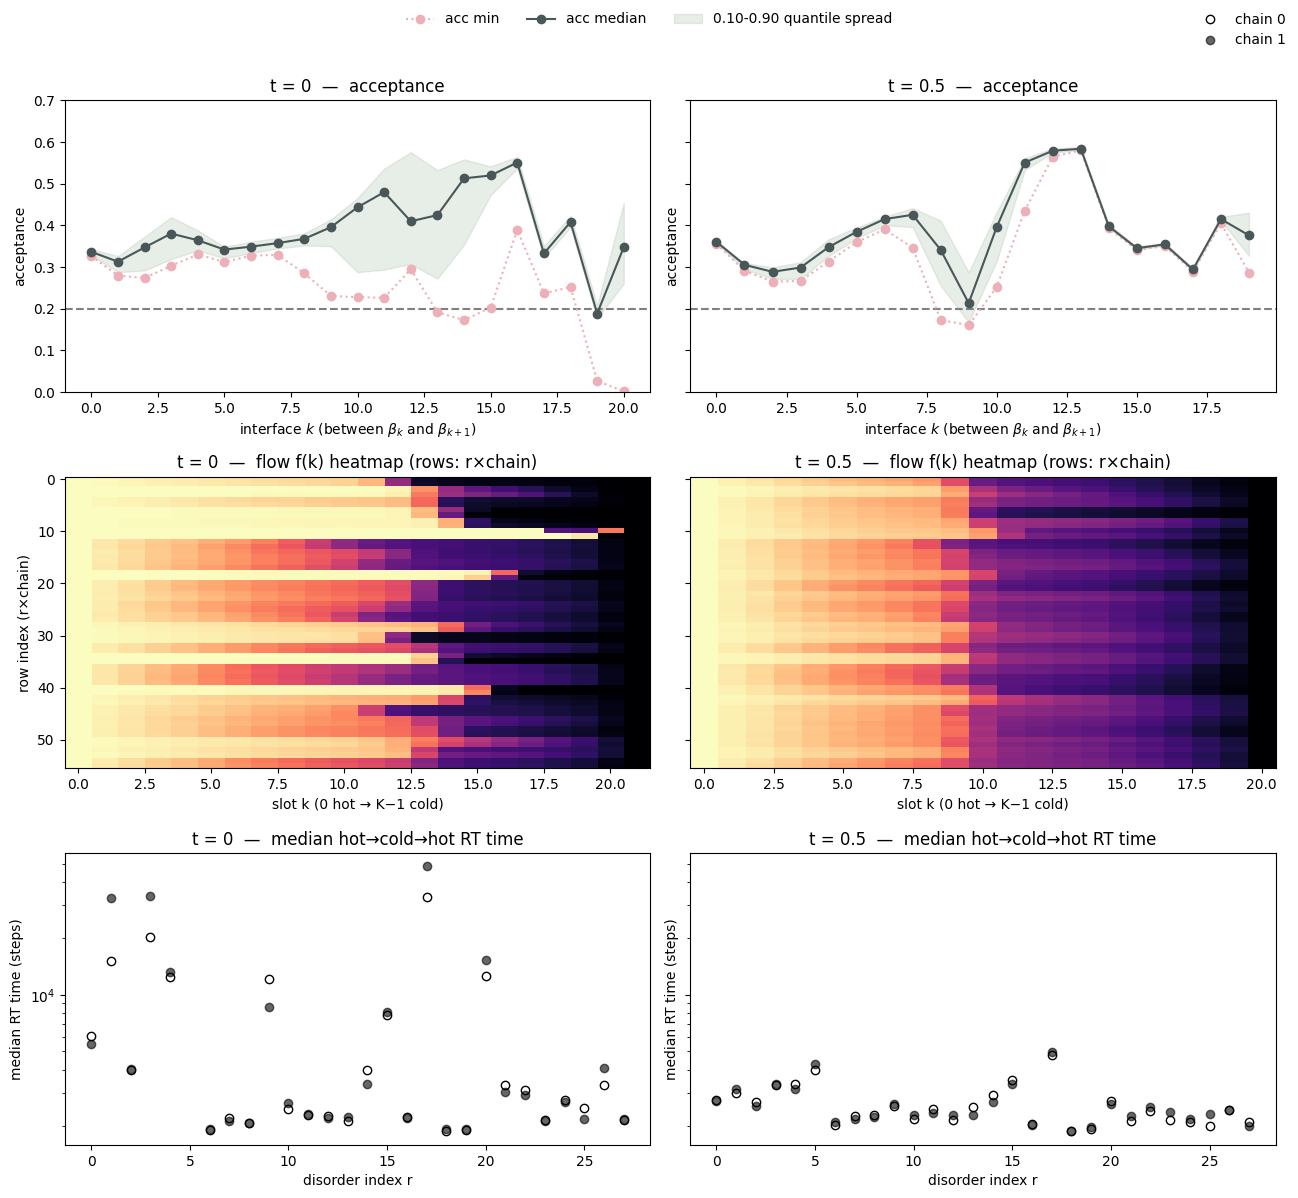

(<Figure size 1300x1200 with 6 Axes>,
 array([[<Axes: title={'center': 't = 0  —  acceptance'}, xlabel='interface $k$ (between $β_k$ and $β_{k+1}$)', ylabel='acceptance'>,
         <Axes: title={'center': 't = 0.5  —  acceptance'}, xlabel='interface $k$ (between $β_k$ and $β_{k+1}$)', ylabel='acceptance'>],
        [<Axes: title={'center': 't = 0  —  flow f(k) heatmap (rows: r×chain)'}, xlabel='slot k (0 hot → K−1 cold)', ylabel='row index (r×chain)'>,
         <Axes: title={'center': 't = 0.5  —  flow f(k) heatmap (rows: r×chain)'}, xlabel='slot k (0 hot → K−1 cold)'>],
        [<Axes: title={'center': 't = 0  —  median hot→cold→hot RT time'}, xlabel='disorder index r', ylabel='median RT time (steps)'>,
         <Axes: title={'center': 't = 0.5  —  median hot→cold→hot RT time'}, xlabel='disorder index r', ylabel='median RT time (steps)'>]],
       dtype=object))

In [26]:
compare_pt_diagnostics_3x2(
    I_ts_t0_stack,  betas_t0,  acc_t0_stack,
    I_ts_t05_stack, betas_t05, acc_t05_stack,
    burn_in=0, q_lo=0.10, chains=(0,1),
)

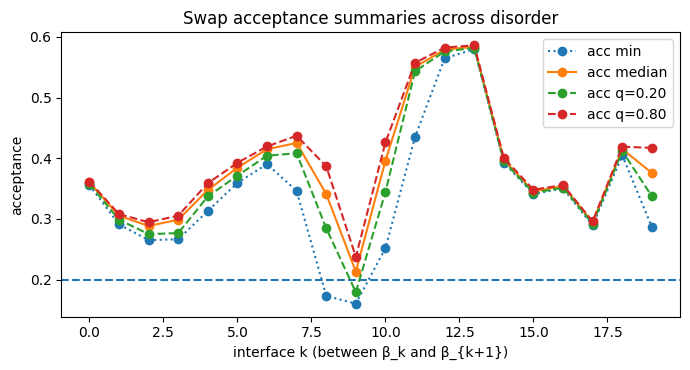

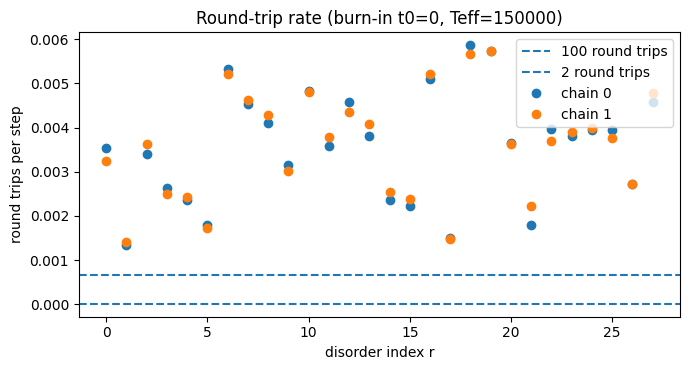

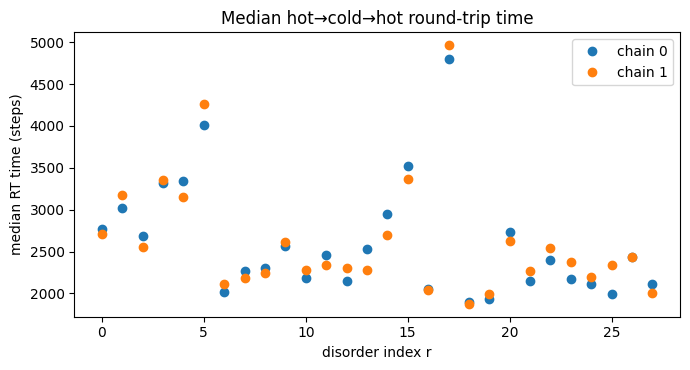

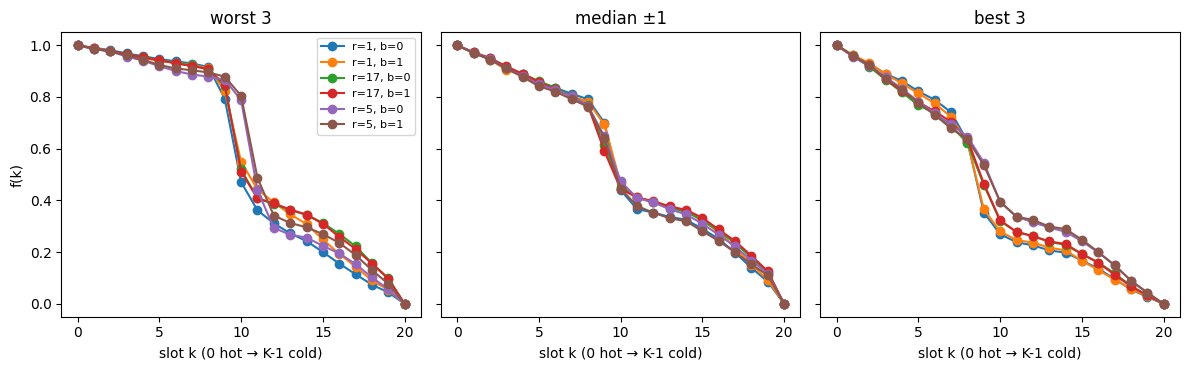

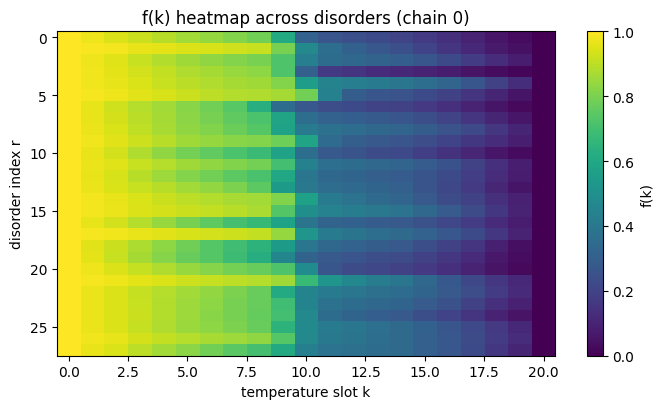

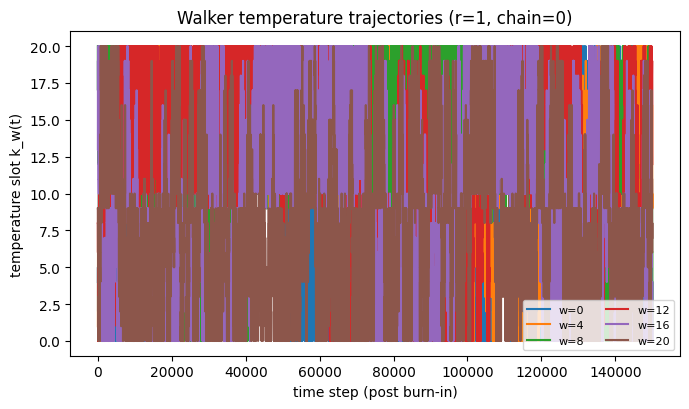

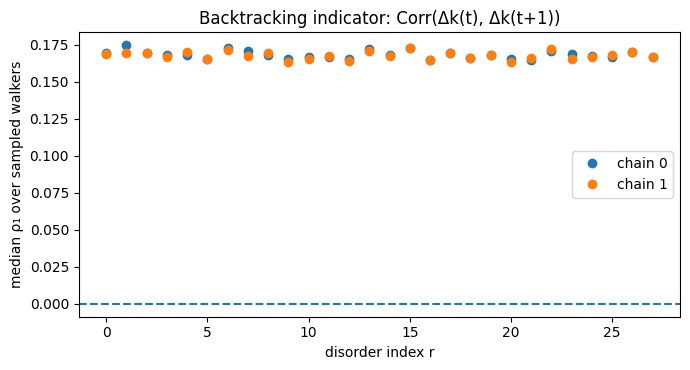

In [9]:
out=pt_diagnostics_report(
    I_ts_t05_stack,
    betas_t05,
    acc_t05_stack)

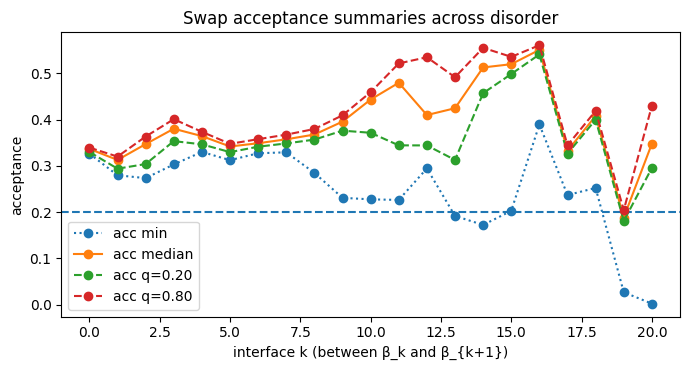

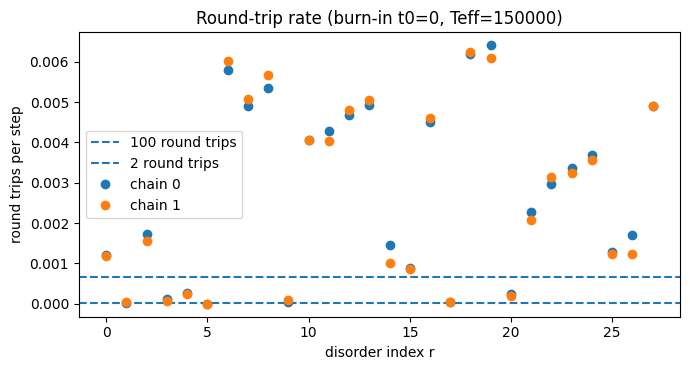

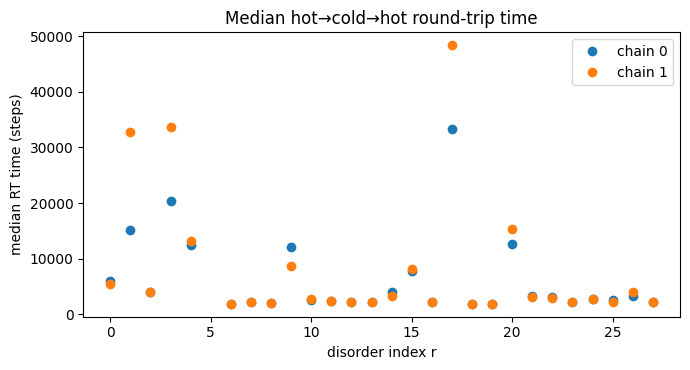

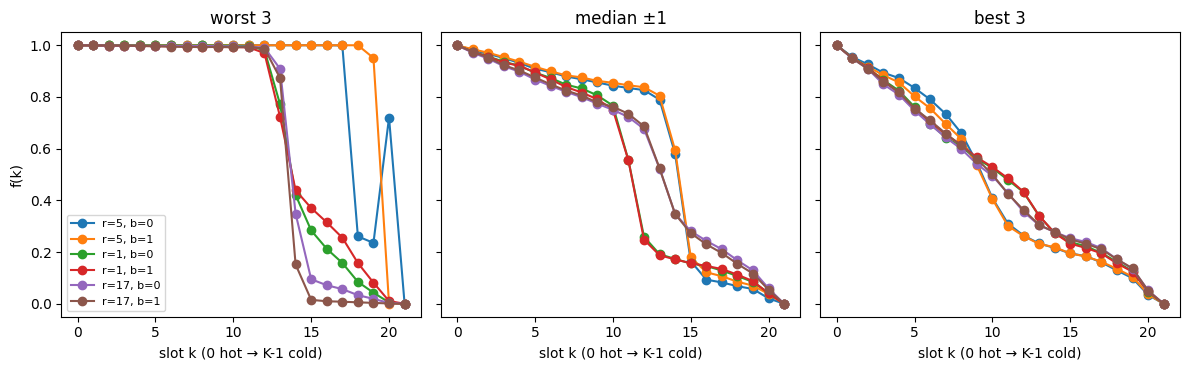

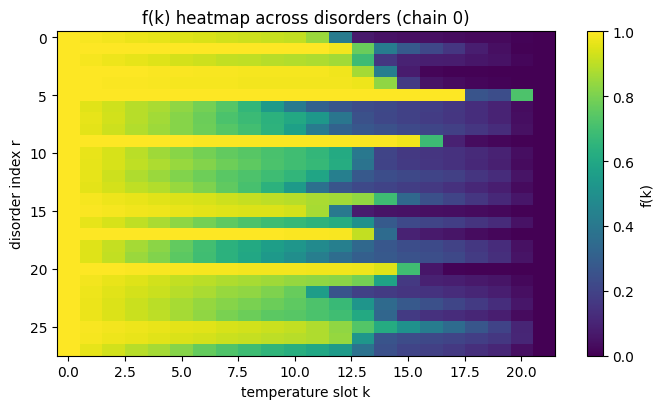

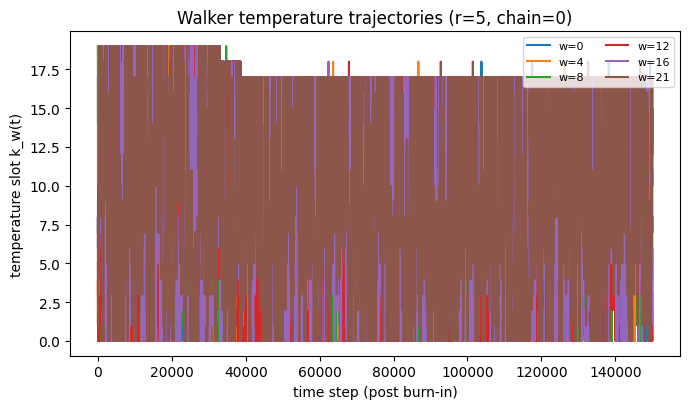

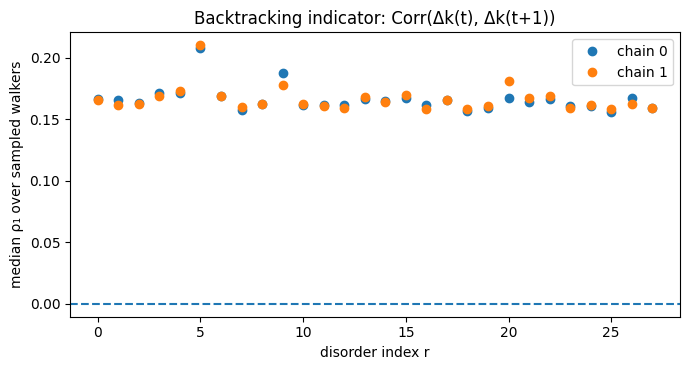

In [10]:
out=pt_diagnostics_report(
    I_ts_t0_stack,
    betas_t0,
    acc_t0_stack)